In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
csv_ffiv = "C:/Business analysis/Project/IS403.O22.HTCLL_Nhom07/Dataset/FFIV_Stock.csv"
df_ffiv = pd.read_csv(csv_ffiv, thousands=',')

In [3]:
df_ffiv.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,FFIV,166.529999,166.529999,168.330002,165.419998,167.600006,756400
1,3/4/2019,FFIV,163.289993,163.289993,167.289993,161.710007,166.970001,553700
2,3/5/2019,FFIV,162.149994,162.149994,163.399994,161.970001,163.240005,511300
3,3/6/2019,FFIV,161.080002,161.080002,162.139999,159.949997,161.919998,527000
4,3/7/2019,FFIV,158.990005,158.990005,161.250000,157.910004,160.630005,783200


In [4]:
df_ffiv.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,163.434992,163.434992,165.268542,161.482228,163.397160,6.147710e+05
std,29.329932,29.329932,29.577160,29.115418,29.336975,3.981027e+05
min,90.550003,90.550003,93.830002,79.779999,88.750000,1.205000e+05
25%,141.537506,141.537506,143.384998,139.952503,141.632496,3.971500e+05
50%,155.590004,155.590004,157.345001,154.154999,156.070000,5.293500e+05
75%,186.022503,186.022503,187.654995,184.379997,186.260002,6.974750e+05
max,247.779999,247.779999,249.000000,245.899994,247.779999,5.232700e+06


In [5]:
df_ffiv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [6]:
# Convert object to datetime64
df_ffiv['Date'] = df_ffiv['Date'].apply(pd.to_datetime)
# Sort data by date time value
df_ffiv = df_ffiv.sort_values(by="Date").reset_index(drop=True)
df_ffiv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1324 non-null   datetime64[ns]
 1   Symbol     1324 non-null   object        
 2   Adj Close  1324 non-null   float64       
 3   Close      1324 non-null   float64       
 4   High       1324 non-null   float64       
 5   Low        1324 non-null   float64       
 6   Open       1324 non-null   float64       
 7   Volume     1324 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 82.9+ KB


In [7]:
df_ffiv.Close

0       166.529999
1       163.289993
2       162.149994
3       161.080002
4       158.990005
           ...    
1319    168.339996
1320    168.229996
1321    167.300003
1322    168.970001
1323    166.910004
Name: Close, Length: 1324, dtype: float64

In [8]:
rows = []
for _,row in tqdm(df_ffiv.iterrows(), total=df_ffiv.shape[0]):
    row_data = dict(
        date = row.Date,
        open = row.Open,
        low = row.Close,
        high = row.High, 
        close = row.Close, 
        volume = row.Volume,
    )
    rows.append(row_data)
features_ffiv = pd.DataFrame(rows)

  0%|          | 0/1324 [00:00<?, ?it/s]

In [9]:
features_ffiv.head()

,date,open,low,high,close,volume
0,2019-03-01,167.600006,166.529999,168.330002,166.529999,756400
1,2019-03-04,166.970001,163.289993,167.289993,163.289993,553700
2,2019-03-05,163.240005,162.149994,163.399994,162.149994,511300
3,2019-03-06,161.919998,161.080002,162.139999,161.080002,527000
4,2019-03-07,160.630005,158.990005,161.250000,158.990005,783200


In [10]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [11]:
detect_outlier(features_ffiv, 'close')

Empty DataFrame
Columns: [date, open, low, high, close, volume]
Index: []


In [12]:
features_ffiv = features_ffiv.set_index("date")
features_ffiv.head()

,open,low,high,close,volume
date,,,,,
2019-03-01,167.600006,166.529999,168.330002,166.529999,756400
2019-03-04,166.970001,163.289993,167.289993,163.289993,553700
2019-03-05,163.240005,162.149994,163.399994,162.149994,511300
2019-03-06,161.919998,161.080002,162.139999,161.080002,527000
2019-03-07,160.630005,158.990005,161.250000,158.990005,783200


In [13]:
train_size = int(0.7 * len(features_ffiv))
test_size = len(features_ffiv)-train_size

train_ffiv_df = features_ffiv[:train_size]
test_ffiv_df = features_ffiv[train_size:]

Text(0.5, 1.0, 'Time Series Plots of ffiv stock')

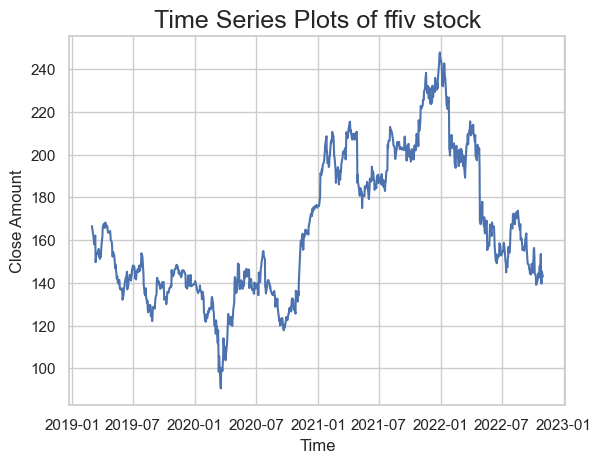

In [14]:
fig, ax = plt.subplots()
ax.plot(train_ffiv_df.index, train_ffiv_df['close'])
ax.set_ylabel('Close Amount')
ax.set_xlabel('Time')
ax.set_title('Time Series Plots of ffiv stock', size=18)

The additive method is useful when the trend and seasonal variation is relatively constant over time as shown below whereas the multiplicative method is useful when the trend and seasonal variation increases or decreases in magnitude over time

Text(0.5, 0, 'Y')

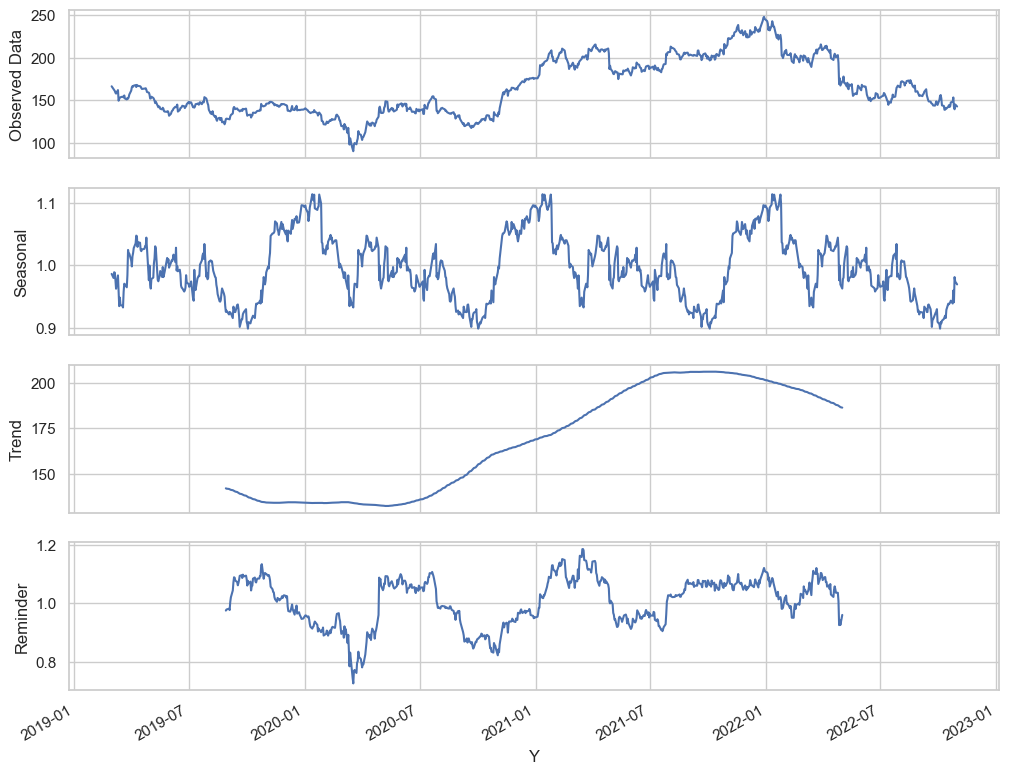

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(train_ffiv_df['close'], model='multiplicative', period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Y")

In [16]:
# Define your parameter grid
param_grid = {
    'error': ['add', 'mul'],
    'trend': ['add','mul', None],
    'damped_trend': [False, True],
    'seasonal': ['add', None, 'mul'],
    'seasonal_periods': [7, 14, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
}

# Initialize variables to store the best score, parameters, and model
best_aic = float('inf')
best_params = None
best_model = None

# Ensure the data passed to ETSModel is 1-dimensional and has date index with frequency
train_series = pd.Series(train_ffiv_df['close'].values, index=pd.date_range(start=train_ffiv_df.index[0], periods=len(train_ffiv_df), freq='D'))
test_series = pd.Series(test_ffiv_df['close'].values, index=pd.date_range(start=test_ffiv_df.index[0], periods=len(test_ffiv_df), freq='D'))

# Iterate over all combinations of parameters
for error in param_grid['error']:
    for trend in param_grid['trend']:
        damped_trend_values = [False] if trend is None else param_grid['damped_trend']
        for damped_trend in damped_trend_values:
            for seasonal in param_grid['seasonal']:
                for seasonal_periods in param_grid['seasonal_periods']:
                    try:
                        # Check if seasonal_periods is valid with the given seasonal component
                        if seasonal is None and seasonal_periods is not None:
                            continue
                        
                        # Define and fit the model
                        model = ETSModel(train_series, 
                                         error=error,
                                         trend=trend,
                                         damped_trend=damped_trend, 
                                         seasonal=seasonal, 
                                         seasonal_periods=seasonal_periods,
                                         initialization_method='heuristic')
                        model_fit = model.fit()

                        # Make predictions with date index preserved
                        # Get AIC score
                        aic_score = model_fit.aic
                        
                        # Update the best model if the current one has lower AIC
                        if aic_score < best_aic:
                            best_aic = aic_score
                            best_params = {
                                'error': error,
                                'trend': trend,
                                'damped_trend': damped_trend,
                                'seasonal': seasonal,
                                'seasonal_periods': seasonal_periods
                            }
                            best_model = model_fit

                    except Exception as e:
                        print(f"An error occurred for parameters (error={error}, trend={trend}, damped_trend={damped_trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}): {e}")
                        continue

# Output the best model's AIC
if best_model is not None:
    print('Best model')
    print(f"Best Parameters: {best_params}")
    print(f"Best AIC: {best_aic}")

Best model
Best Parameters: {'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 180}
Best AIC: 4770.9963451315325


In [17]:
# Quá trình testing
# Forecast the values for the test set
test_predictions = best_model.predict(start=len(train_ffiv_df), end=len(train_ffiv_df) + len(test_ffiv_df) - 1 )
test_dates = pd.Series(test_ffiv_df.index)  # Adjust freq as per your data
y_pred = test_predictions
test_predictions.index = test_dates
# Output the forecasted values for the test set
print("Test Set Predictions:")
print(test_predictions)

Test Set Predictions:
date
2022-11-01    141.298293
2022-11-02    141.536060
2022-11-03    143.247473
2022-11-04    142.950845
2022-11-07    144.891610
                 ...    
2024-05-28    144.863914
2024-05-29    144.492280
2024-05-30    145.959146
2024-05-31    145.151129
2024-06-03    146.058103
Length: 398, dtype: float64


In [18]:
#Evaluating algorithm accuracy using
y_test = test_ffiv_df['close']
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)

Testing RMSE: 19.679213816315556
Testing MAE: 16.498860583499685
Testing MAPE: 0.10073860621825516


In [19]:
#Predict the closing prices for the next 30 days
forecast_horizon = 30
forecast_dates = pd.date_range(start=features_ffiv.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_30_days = best_model.predict(start=len(features_ffiv), end=len(features_ffiv) + forecast_horizon - 1)
forecast_30_days.index = forecast_dates
print(forecast_30_days)

2024-06-04    147.316156
2024-06-05    146.982528
2024-06-06    151.409253
2024-06-07    151.832041
2024-06-08    151.905515
2024-06-09    152.118474
2024-06-10    152.915882
2024-06-11    153.646425
2024-06-12    153.668360
2024-06-13    152.681266
2024-06-14    154.649522
2024-06-15    149.453195
2024-06-16    144.228166
2024-06-17    143.935469
2024-06-18    143.413335
2024-06-19    142.137019
2024-06-20    139.802422
2024-06-21    142.327312
2024-06-22    136.573058
2024-06-23    136.140235
2024-06-24    135.034112
2024-06-25    138.402779
2024-06-26    138.715765
2024-06-27    138.815356
2024-06-28    141.161851
2024-06-29    141.898913
2024-06-30    146.890068
2024-07-01    145.951875
2024-07-02    145.746980
2024-07-03    146.020636
Freq: D, dtype: float64


In [20]:
#Predict the closing prices for the next 60 days
forecast_horizon = 60
forecast_dates = pd.date_range(start=features_ffiv.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_60_days = best_model.predict(start=len(features_ffiv), end=len(features_ffiv) + forecast_horizon - 1)
forecast_60_days.index = forecast_dates
print(forecast_60_days)

2024-06-04    147.316156
2024-06-05    146.982528
2024-06-06    151.409253
2024-06-07    151.832041
2024-06-08    151.905515
2024-06-09    152.118474
2024-06-10    152.915882
2024-06-11    153.646425
2024-06-12    153.668360
2024-06-13    152.681266
2024-06-14    154.649522
2024-06-15    149.453195
2024-06-16    144.228166
2024-06-17    143.935469
2024-06-18    143.413335
2024-06-19    142.137019
2024-06-20    139.802422
2024-06-21    142.327312
2024-06-22    136.573058
2024-06-23    136.140235
2024-06-24    135.034112
2024-06-25    138.402779
2024-06-26    138.715765
2024-06-27    138.815356
2024-06-28    141.161851
2024-06-29    141.898913
2024-06-30    146.890068
2024-07-01    145.951875
2024-07-02    145.746980
2024-07-03    146.020636
2024-07-04    145.030466
2024-07-05    145.387486
2024-07-06    145.646633
2024-07-07    147.471446
2024-07-08    148.075825
2024-07-09    149.372832
2024-07-10    150.562300
2024-07-11    150.820191
2024-07-12    152.510999
2024-07-13    150.585545


In [21]:
#Predict the closing prices for the next 90 days
forecast_horizon = 90
forecast_dates = pd.date_range(start=features_ffiv.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_90_days = best_model.predict(start=len(features_ffiv), end=len(features_ffiv) + forecast_horizon - 1)
forecast_90_days.index = forecast_dates
print(forecast_90_days)

2024-06-04    147.316156
2024-06-05    146.982528
2024-06-06    151.409253
2024-06-07    151.832041
2024-06-08    151.905515
                 ...    
2024-08-28    156.964672
2024-08-29    157.372180
2024-08-30    158.287021
2024-08-31    156.749269
2024-09-01    157.605000
Freq: D, Length: 90, dtype: float64


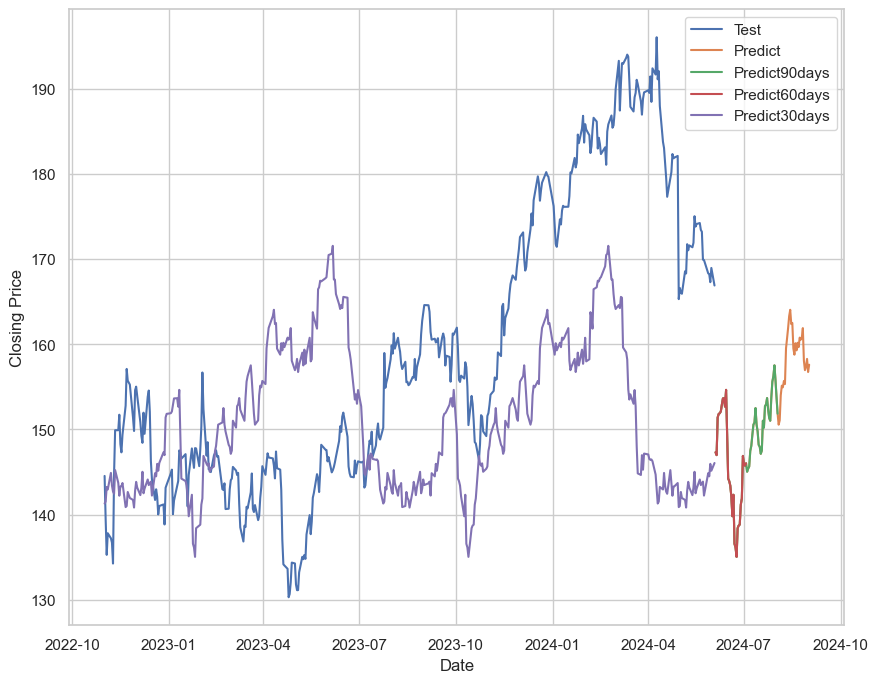

In [22]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(test_ffiv_df['close'])
plt.plot(forecast_90_days)
plt.plot(forecast_60_days)
plt.plot(forecast_30_days)
plt.plot(test_predictions)
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

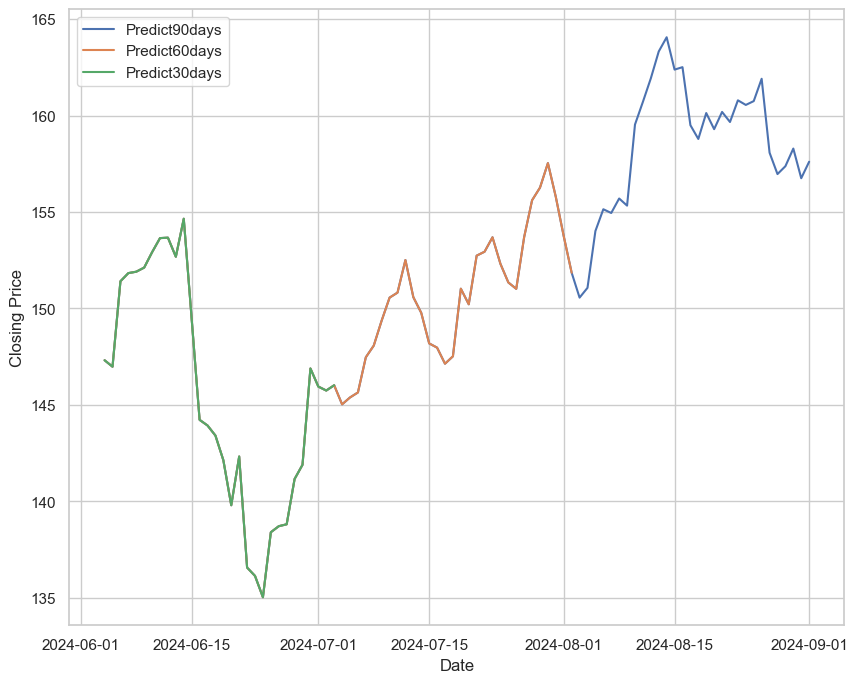

In [23]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(forecast_90_days)
plt.plot(forecast_60_days)
plt.plot(forecast_30_days)
plt.legend(['Predict90days', 'Predict60days', 'Predict30days'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()